In this kernel, our group have followed following steps for model building and evaluation: 

> Step 1. Data analysis and preprocessing

> Step 2. Model building

> Step 3. Model training

> Step 4. Model evaluation



 ### First, import all libraries that used in this project

In [ ]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
import torch.nn.functional as F

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

import multiprocessing

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Step 1. Data analysis and preprocessing

Get the all image data paths， match the row information in HAM10000_metadata.csv with its corresponding image

In [ ]:
data_dir = '/content/drive/Shared drives/CNN_Skin_Cancer_Detection/Colab/data/skin_cancer'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

This function is used to compute the mean and standard deviation on the whole dataset, will use for inputs normalization

In [ ]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

Return the mean and std of RGB channels

In [ ]:
#norm_mean,norm_std = compute_img_mean_std(all_image_path)
norm_mean = [0.763038, 0.54564667, 0.57004464]
norm_std = [0.14092727, 0.15261286, 0.1699712]

In [ ]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes

In [ ]:
# Check if theres any NULL value in the dataset
df_original.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [ ]:
# Fill NULL values with median
df_original['age'].fillna((-1), inplace=True)

In [ ]:
# Label encoding
df_original['MR_dx_type'] = df_original['dx_type'].map(df_original['dx_type'].value_counts(dropna = False))
df_original['MR_age'] = df_original['age'].map(df_original['age'].value_counts(dropna = False))
df_original['MR_sex'] = df_original['sex'].map(df_original['sex'].value_counts(dropna = False))
df_original['MR_localization'] = df_original['localization'].map(df_original['localization'].value_counts(dropna = False))

In [ ]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,MR_dx_type,MR_age,MR_sex,MR_localization
0,HAM_0000001,1,1,1,1,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)

In [ ]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [ ]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 15)

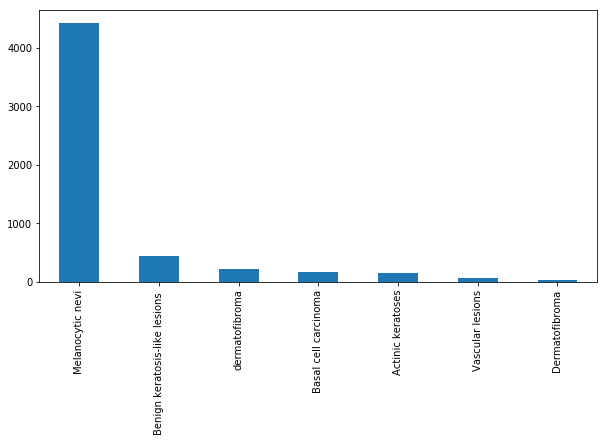

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df_undup['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
# now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 15)

In [ ]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: cell_type_idx, dtype: int64

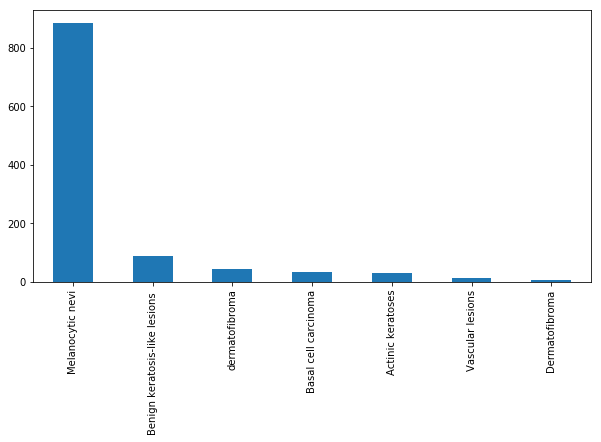

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df_val['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [ ]:
df_train['cell_type_idx'].value_counts()

4    5822
6    1067
2    1011
1     479
0     297
5     129
3     107
Name: cell_type_idx, dtype: int64

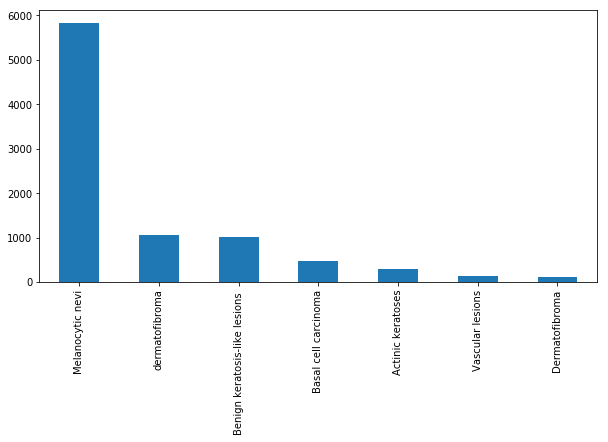

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df_train['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
dermatofibroma                     46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

**From the above statistics of each category, we can see that there is a serious class imbalance in the training data. To solve this problem, I think we can start from two aspects, one is equalization sampling, and the other is a loss function that can be used to mitigate category imbalance during training, such as focal loss.**

In [ ]:
# Copy fewer class to balance the number of 7 classes
'''
data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()
'''

"\ndata_aug_rate = [15,10,5,50,0,40,5]\nfor i in range(7):\n    if data_aug_rate[i]:\n        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)\ndf_train['cell_type'].value_counts()\n"

At the beginning, I divided the data into three parts, training set, validation set and test set. Considering the small amount of data, I did not further divide the validation set data in practice.

In [ ]:
# # We can split the test set again in a validation set and a true test set:
# df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
# df_test = df_test.reset_index()

In [ ]:
df_train.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,MR_dx_type,MR_age,MR_sex,MR_localization,duplicates,train_or_val
0,0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/Shared drives/ECE4179/Colab/dat...,Benign keratosis-like lesions,2,5340,404,5406,128,duplicated,train
1,1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/Shared drives/ECE4179/Colab/dat...,Benign keratosis-like lesions,2,5340,404,5406,128,duplicated,train
2,2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/Shared drives/ECE4179/Colab/dat...,Benign keratosis-like lesions,2,5340,404,5406,128,duplicated,train
3,3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/Shared drives/ECE4179/Colab/dat...,Benign keratosis-like lesions,2,5340,404,5406,128,duplicated,train
4,4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/Shared drives/ECE4179/Colab/dat...,Benign keratosis-like lesions,2,5340,618,5406,56,duplicated,train


In [ ]:
df_val.head()

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,MR_dx_type,MR_age,MR_sex,MR_localization,duplicates
0,4781,HAM_0000199,ISIC_0026127,nv,follow_up,55.0,male,lower extremity,/content/drive/Shared drives/ECE4179/Colab/dat...,Melanocytic nevi,4,3704,1009,5406,2077,unduplicated
1,3294,HAM_0006655,ISIC_0025994,nv,follow_up,50.0,female,lower extremity,/content/drive/Shared drives/ECE4179/Colab/dat...,Melanocytic nevi,4,3704,1187,4552,2077,unduplicated
2,2089,HAM_0006004,ISIC_0027702,mel,histo,70.0,female,back,/content/drive/Shared drives/ECE4179/Colab/dat...,dermatofibroma,6,5340,756,4552,2192,unduplicated
3,9816,HAM_0004563,ISIC_0031211,akiec,histo,75.0,male,lower extremity,/content/drive/Shared drives/ECE4179/Colab/dat...,Actinic keratoses,0,5340,618,5406,2077,unduplicated
4,8611,HAM_0004275,ISIC_0026921,nv,histo,70.0,female,back,/content/drive/Shared drives/ECE4179/Colab/dat...,Melanocytic nevi,4,5340,756,4552,2192,unduplicated


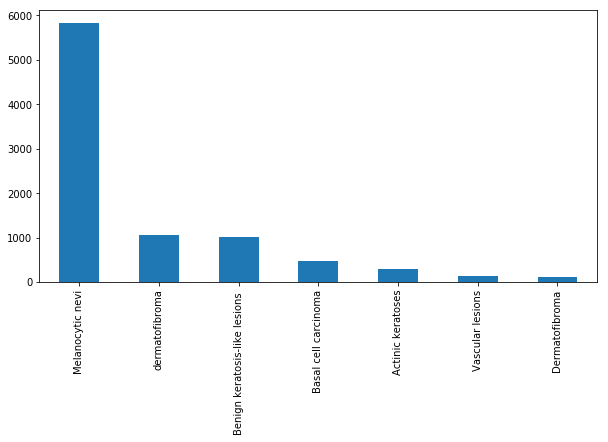

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df_train['cell_type'].value_counts().plot(kind='bar', ax=ax1)

## Step 2. Model building

In [ ]:
class CNN_WRAP(nn.Module):
  def __init__(self, model_ft):
    super(CNN_WRAP, self).__init__()
    self.cnn_out = model_ft

    self.mr1 = nn.Linear(3, 8)
    self.mr1_bn = nn.BatchNorm1d(8)
    self.mr1_drop = nn.Dropout(0.5)

    
    self.fc1 = nn.Linear(24, 7)

  def forward(self, x, mr):
    y_cnn = self.cnn_out(x)

    y_mr = F.relu(self.mr1_drop(self.mr1_bn(self.mr1(mr))))
    x = self.fc1(torch.cat((y_cnn, y_mr), 1))
    return F.log_softmax(x, dim=1)


In [ ]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224


    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    elif model_name == "custom":
      model_ft = DeepCNN()
      input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    model_ft = CNN_WRAP(model_ft)

    return model_ft, input_size

You can change your backbone network, here are 4 different networks, each network also has sevaral versions. Considering the limited training data, we used the ImageNet pre-training model for fine-tuning. This can speed up the convergence of the model and improve the accuracy.

There is one thing you need to pay attention to, the input size of Inception is different from the others (299x299), you need to change the setting of compute_img_mean_std() function 

In [ ]:
# resnet,vgg,densenet,inception
#model_name = 'densenet'
model_name = 'densenet'
num_classes = 16
feature_extract = False
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# Put the model on the device:
model = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 16.8MB/s]


In [ ]:
# norm_mean = (0.49139968, 0.48215827, 0.44653124)
# norm_std = (0.24703233, 0.24348505, 0.26158768)
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std)])
# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [ ]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        MR = torch.FloatTensor([self.df[feat][index] for feat in ['MR_age', 'MR_sex', 'MR_localization']])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, MR, y

In [ ]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
n_workers = multiprocessing.cpu_count()
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=n_workers)
# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=n_workers)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.CrossEntropyLoss().to(device)
criterion = FocalLoss(gamma=2.0).to(device)

## Step 3. Model training

In [ ]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, mr, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        mr = Variable(mr).to(device)

        optimizer.zero_grad()
        outputs = model(images, mr)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        '''
        print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
            epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
        total_loss_train.append(train_loss.avg)
        total_acc_train.append(train_acc.avg)
        '''

        if (i + 1) % 50 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)

    return train_loss.avg, train_acc.avg

In [ ]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, mr, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            mr = Variable(mr).to(device)

            outputs = model(images, mr)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [ ]:
save_dir = '/content/drive/Shared drives/CNN_Skin_Cancer_Detection/Colab/model'
model_name = 'CNN_Skin_Cancer_Detection_Project'
start_from_checkpoint = False
start_epoch = 1
#Create Save Path from save_dir and model_name, we will save and load our checkpoint here
save_path = os.path.join(save_dir, model_name + ".pt")

#Create the save directory if it does note exist
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

#Load Checkpoint
if start_from_checkpoint:
    #Check if checkpoint exists
    if os.path.isfile(save_path):
        #load Checkpoint
        check_point = torch.load(save_path)
        #Checkpoint is saved as a python dictionary
        #https://www.w3schools.com/python/python_dictionaries.asp
        #here we unpack the dictionary to get our previous training states
        model.load_state_dict(check_point['model_state_dict'])
        optimizer.load_state_dict(check_point['optimizer_state_dict'])
        start_epoch = check_point['epoch']
        print("Checkpoint loaded, starting from epoch:", start_epoch)
    else:
        #Raise Error if it does not exist
        raise ValueError("Checkpoint Does not exist")
else:
    #If checkpoint does exist and Start_From_Checkpoint = False
    #Raise an error to prevent accidental overwriting
    if os.path.isfile(save_path):
        raise ValueError("Warning Checkpoint exists")
    else:
        print("Starting from scratch")

In [ ]:
epoch_num = 20
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        torch.save({
            'epoch':                 epoch,
            'model_state_dict':      model.state_dict(),
            'optimizer_state_dict':  optimizer.state_dict(), 
            'train_acc':             acc_train,
            'valid_acc':             acc_val,
        }, save_path)
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 50 / 279], [train loss 0.67978], [train acc 0.61938]
[epoch 1], [iter 100 / 279], [train loss 0.61137], [train acc 0.63750]
[epoch 1], [iter 150 / 279], [train loss 0.59442], [train acc 0.64583]
[epoch 1], [iter 200 / 279], [train loss 0.57533], [train acc 0.65656]
[epoch 1], [iter 250 / 279], [train loss 0.56311], [train acc 0.65838]
------------------------------------------------------------
[epoch 1], [val loss 0.34894], [val acc 0.78738]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.34894], [val acc 0.78738]
*****************************************************
[epoch 2], [iter 50 / 279], [train loss 0.49472], [train acc 0.67750]
[epoch 2], [iter 100 / 279], [train loss 0.48916], [train acc 0.68625]
[epoch 2], [iter 150 / 279], [train loss 0.48309], [train acc 0.68792]
[epoch 2], [iter 200 / 279], [train loss 0.48110], [train acc 0.68703]
[epoch 2], [iter 250 /

In [ ]:
save_dir = '/content/drive/Shared drives/CNN_Skin_Cancer_Detection/Colab/model'
model_name = 'CNN_Skin_Cancer_Detection_Project'
start_from_checkpoint = True
start_epoch = 1
#Create Save Path from save_dir and model_name, we will save and load our checkpoint here
save_path = os.path.join(save_dir, model_name + ".pt")

#Create the save directory if it does note exist
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

#Load Checkpoint
if start_from_checkpoint:
    #Check if checkpoint exists
    if os.path.isfile(save_path):
        #load Checkpoint
        check_point = torch.load(save_path)
        #Checkpoint is saved as a python dictionary
        #https://www.w3schools.com/python/python_dictionaries.asp
        #here we unpack the dictionary to get our previous training states
        model.load_state_dict(check_point['model_state_dict'])
        optimizer.load_state_dict(check_point['optimizer_state_dict'])
        start_epoch = check_point['epoch']
        print("Checkpoint loaded, starting from epoch:", start_epoch)
    else:
        #Raise Error if it does not exist
        raise ValueError("Checkpoint Does not exist")
else:
    #If checkpoint does exist and Start_From_Checkpoint = False
    #Raise an error to prevent accidental overwriting
    if os.path.isfile(save_path):
        raise ValueError("Warning Checkpoint exists")
    else:
        print("Starting from scratch")

## Step 4. Model evaluation

In [ ]:
def plot_acc(num_epochs, training_acc_logger, validation_acc_logger):
  plt.figure(figsize = (10,10))
  train_x = np.linspace(0, num_epochs, len(training_acc_logger))
  plt.plot(train_x, training_acc_logger, c = "y")
  valid_x = np.linspace(0, num_epochs, len(validation_acc_logger))
  plt.plot(valid_x, validation_acc_logger, c = "k")

  plt.title('Accuracy')
  plt.legend(["Training Acc", "Validation Acc"])
  plt.show()

def plot_result(num_epochs, training_loss_logger, validation_loss_logger):
  #plot out the training_loss_logger and validation_loss_logger
  plt.figure(figsize = (10,10))
  train_x = np.linspace(0, num_epochs, len(training_loss_logger))
  plt.plot(train_x, training_loss_logger, c = "y")
  valid_x = np.linspace(0, num_epochs, len(validation_loss_logger))
  plt.plot(valid_x, validation_loss_logger, c = "k")

  plt.title(f'Epoch: {num_epochs}')
  plt.legend(["Training Loss", "Validation Loss"])
  plt.ylim(0, 5)
  plt.show()

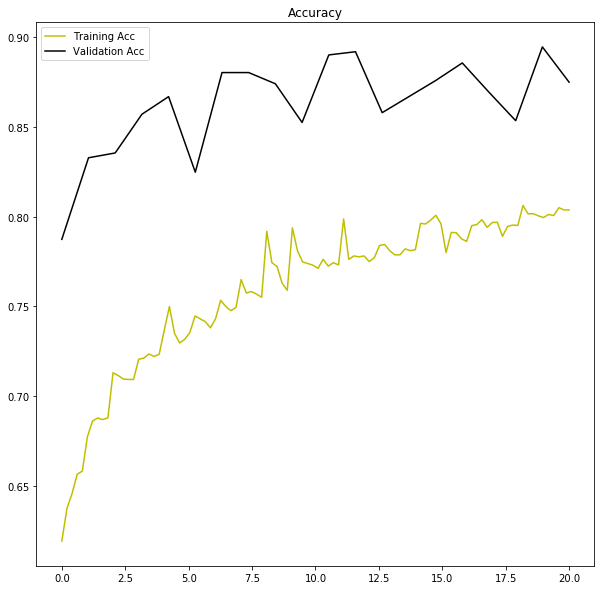

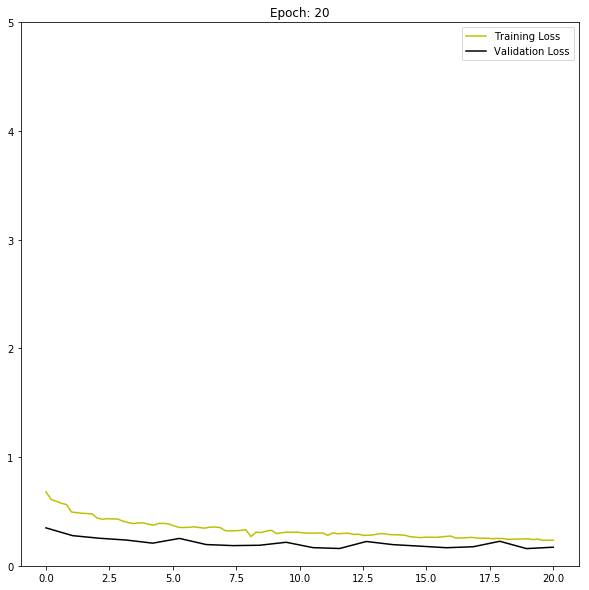

In [ ]:
plot_acc(20, total_acc_train, total_acc_val)
plot_result(20, total_loss_train, total_loss_val)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

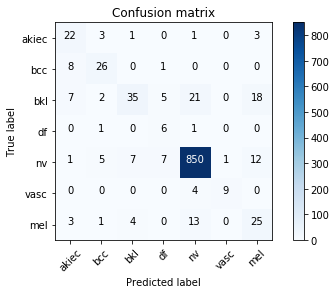

In [ ]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, mr, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        mr = Variable(mr).to(device)
        outputs = model(images, mr)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [ ]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.54      0.73      0.62        30
         bcc       0.68      0.74      0.71        35
         bkl       0.74      0.40      0.52        88
          df       0.32      0.75      0.44         8
          nv       0.96      0.96      0.96       883
        vasc       0.90      0.69      0.78        13
         mel       0.43      0.54      0.48        46

    accuracy                           0.88      1103
   macro avg       0.65      0.69      0.65      1103
weighted avg       0.89      0.88      0.88      1103



Text(0, 0.5, 'Fraction classified incorrectly')

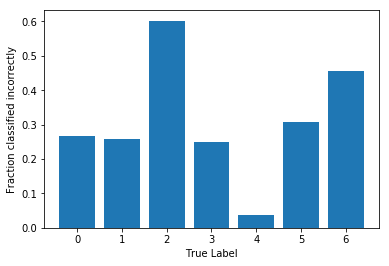

In [ ]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [ ]:
from sklearn.preprocessing import LabelBinarizer
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)

multiclass_roc_auc_score(y_label, y_predict)

0.8254097811893117

## Conclusion

I tried to train with different network structures. When using Densenet-121, the average accuracy of 7 classes on the validation set can reach 92% in 10 epochs. We also calculated the confusion matrix for all classes and the F1-score for each class, which is a more comprehensive indicator that can take into account both the precision and recall of the classification model.Our model can achieve more than 90% on the F1-score indicator.

Due to limited time, we did not spend much time on model training. By increasing in training epochs, adjustmenting of model hyperparameters, and attempting at different networks may further enhance the performance of the model.

## Next plan

How to use image data and patient case data at the same time, my plan is to use CNN to extract features from images, use xgboost to convert medical records into vectors and then concat them with CNN network full-layer features. Two branch networks are trained simultaneously using a loss function. We can refer to the methods used in the advertising CTR estimation task.